<a href="https://colab.research.google.com/github/ReidelVichot/GrantAssistProgram/blob/main/Copy_of_RandomForest_solution_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following the paper "Examining the feasibility of using open data to benchmark building energy usage in cities: A data science and policy perspective" [Roth et al 2019](https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective), choose 2 cities in the dataset available through the paper's github repository https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking

This paper is an excellent example of reproducible research. 

I also created an example of using random forest classifier and regressors here https://github.com/fedhere/PUS2022_FBianco/blob/master/classdemo/COVID19LOS_featureExtractionRFexample.ipynb and there are links at the bottom of this notebook to useful functions and examples on the internet of applications of methods you will need to use.

1. Read the introduction to the paper and describe here (briefly) the goals of their analysis (and the analysis that you are about to reproduce). Max 200 words.

  Studies have shown gaps in buildings’ energy efficiency. Meaning that most efficient energetical technologies are not correctly implemented. This gap probably happens because of market barriers, imperfect information, hidden costs, regulatory failures, and behavioral negligence. 
  The urgency for action has motivated global initiatives like the United Nations Sustainable Development Goals (SDGs) and the Paris Climate Agreement that aim at reducing energy consumption. Some major cities worldwide committed to making all new buildings from 2030 carbon-neutral and older buildings carbon-neutral by 2050. 
  Reducing the energy consumption of buildings has important implications for environmental, economic, and social health. The increase in buildings’ energy efficiency can reduce the demand for electricity and, therefore, the amounts of carbon dioxide emitted to the atmosphere. Building energy benchmarking policies is among some of cities' responses to the benefits of implementing energy-efficient policies.  
  The paper (Roth et al., 2019) tries to answer the following questions: 
  *   Can city-wide energy benchmarking be conducted using only open data and how do such models compare to the current practice?
  *   What benchmarking data fields are important for cities to collect?
  *   What policies and programs improve the efficacy of energy benchmarking programs?


2. Choose 2 cities (any 2 cities except Seattle cause I am running some of the Seattle analysis below for guidance)

  *   Chicago
  *   DC
   

3. For each of the 2 cities reproduce their analysis by 

  3.1 gathering the original data from their repository (see below for Seattle example)

  3.2 clean the data according to their data preparation scheme, including one-hot-encoding categorical variables, except to impute missing data using KNearestNeighors instead of Gibbs sampling (see below)

  3.3 run a Random Forest (RF) Regressor to predict the total energy consumption.

  3.4 evaluate the RF model performance by printing the R2 score (the default score in SKLearn RF) for training and test set (discuss)

  3.5 plot the features sorted by their importance and identify the most important features. are they consistent between the 2 cities? are they consistent with the paper's result?
4 compare the result for the 2 cities (discuss)

5. Extra credit: 

  5.1 modify the target variable to a binary variable choosing the median of the variable values as the the energy threshold and predict whether the value is higher or lower than the threshold
  5.2 Run a Random Forest Classifier to predict if an observation is in the upper 50% percentile or lower 50% percentile (above or below the median threshold)
  5.3 Measure the performance of the model on training and test data
  5.4 Measure the feature importance and assess if the important feature have changed (discuss)

In [330]:
import pandas as pd
import numpy as np

# choose a city and read in the data

In [331]:
seattle = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/master/Seattle/seattle_final.csv")
dc = pd.read_csv("https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/raw/master/DC/DC_final.csv")
chicago = pd.read_csv("https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/raw/master/Chicago/chi_final.csv")

# inspect the dataframe

In [332]:
print("Seattle: there are (rows, columns) = ", (seattle.shape), "in the dataframe")
print("DC: there are (rows, columns) = ", (dc.shape), "in the dataframe")
print("Philadelphia: there are (rows, columns) = ", (chicago.shape), "in the dataframe")

Seattle: there are (rows, columns) =  (3237, 32) in the dataframe
DC: there are (rows, columns) =  (1455, 23) in the dataframe
Philadelphia: there are (rows, columns) =  (2688, 19) in the dataframe


In [333]:
seattle.describe()

,building_id,zip,council_district_code,year_built,num_buildings,num_floors,gross_floor_area_total_SF,gross_floor_area_parking_SF,gross_floor_area_building_SF,gross_floor_area_property_type_first_SF,...,total_site_energy_KBTU,weather_norm_total_site_energy_KBTU,steam_use_KBTU,electricity_KWH,electricity_KBTU,natural_gas_THERMS,natural_gas_KBTU,total_ghg_emissions_MTCO2e,ghg_intensity_KGCO2e,log_total_site_energy_KBTU
count,3237.000000,3237.000000,3237.000000,3237.000000,3237.000000,3237.000000,3.237000e+03,3237.000000,3.237000e+03,3.237000e+03,...,3.237000e+03,3.236000e+03,3.237000e+03,3.237000e+03,3.233000e+03,3237.000000,3.233000e+03,3233.000000,3233.000000,3237.000000
mean,21388.686438,98116.974050,4.435897,1968.331480,1.104109,4.776336,9.379247e+04,7863.288230,8.592918e+04,7.802448e+04,...,4.465401e+06,4.332963e+06,2.250012e+05,9.252171e+05,3.159568e+06,10318.984880,1.033099e+06,94.283334,0.979162,14.515624
std,11991.526930,18.683624,2.121025,33.253769,2.137712,5.554374,2.199404e+05,32413.106507,2.087950e+05,2.018149e+05,...,1.809590e+07,9.887960e+06,3.295630e+06,3.880850e+06,1.324942e+07,27002.442002,2.701696e+06,366.275248,1.159277,1.087077
min,1.000000,98006.000000,1.000000,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,1.128500e+04,5.656000e+03,...,4.429350e+04,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000,0.000000e+00,-0.800000,-0.020000,10.698593
25%,20082.000000,98105.000000,3.000000,1948.000000,1.000000,2.000000,2.830900e+04,0.000000,2.758000e+04,2.498800e+04,...,9.197463e+05,9.619787e+05,0.000000e+00,1.858312e+05,6.340560e+05,0.000000,0.000000e+00,9.250000,0.210000,13.731853
50%,23181.000000,98115.000000,4.000000,1974.000000,1.000000,4.000000,4.379400e+04,0.000000,4.290500e+04,3.952000e+04,...,1.742351e+06,1.837465e+06,0.000000e+00,3.322042e+05,1.133481e+06,2948.820068,2.961260e+05,31.790000,0.590000,14.370746
75%,26007.000000,98122.000000,7.000000,1997.000000,1.000000,5.000000,8.954900e+04,0.000000,8.311800e+04,7.517400e+04,...,3.773034e+06,3.977584e+06,0.000000e+00,7.596037e+05,2.591895e+06,10993.830080,1.102497e+06,83.860000,1.270000,15.143390
max,50226.000000,98272.000000,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,...,8.739237e+08,2.959299e+08,1.349435e+08,1.925775e+08,6.570744e+08,679905.375000,6.799054e+07,12307.160000,16.910000,20.588504


In [334]:
dc.describe()

,Unnamed: 0,ward,year_built,tax_record_floor_area,reported_gross_floor_area,water_use,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU
count,1455.000000,1455.000000,1455.000000,1.455000e+03,1.455000e+03,1.455000e+03,1.441000e+03,1.054000e+03,1184.000000,1455.000000,1393.000000,1455.000000,1393.000000,1454.000000,1454.000000,1.455000e+03,1455.000000
mean,793.997938,3.472852,1940.804811,2.046748e+05,1.897612e+05,5.109905e+04,2.760114e+06,5.853217e+04,62.090372,69.960206,70.745154,171.274433,171.302872,1318.734388,6.674278,1.344870e+07,15.905810
std,469.582655,2.047691,167.230361,2.451302e+05,2.436786e+05,6.163321e+05,4.599984e+06,2.617060e+05,26.792483,30.676317,31.476591,76.707287,76.884877,2458.471157,3.143349,2.843799e+07,0.991320
min,1.000000,1.000000,1000.000000,9.171000e+03,9.171000e+03,0.000000e+00,1.785000e+02,0.000000e+00,1.000000,1.100000,1.100000,1.200000,1.200000,3.100000,0.100000,5.729350e+04,10.955942
25%,380.500000,2.000000,1947.000000,7.164000e+04,7.111750e+04,1.958050e+03,7.435930e+05,1.121760e+04,43.750000,51.600000,51.900000,121.850000,121.600000,400.450000,4.800000,4.513227e+06,15.322523
50%,794.000000,2.000000,1971.000000,1.287720e+05,1.215530e+05,4.063800e+03,1.612028e+06,2.770698e+04,70.000000,65.900000,66.600000,163.300000,163.400000,757.100000,6.300000,8.156027e+06,15.914268
75%,1176.500000,5.000000,1994.000000,2.585310e+05,2.372130e+05,7.008700e+03,3.386553e+06,5.154631e+04,84.000000,82.850000,84.500000,206.450000,207.400000,1534.450000,7.800000,1.565570e+07,16.566343
max,2181.000000,8.000000,2017.000000,3.997572e+06,5.634890e+06,1.929391e+07,1.207430e+08,7.269109e+06,100.000000,213.600000,215.500000,618.600000,620.600000,64992.500000,30.600000,7.832497e+08,20.478962


In [335]:
chicago.describe()

,Unnamed: 0,ID,Gross.Floor.Area...Buildings..sq.ft.,Year.Built,X..of.Buildings,ENERGY.STAR.Score,Electricity.Use..kBtu.,Natural.Gas.Use..kBtu.,Site.EUI..kBtu.sq.ft.,Source.EUI..kBtu.sq.ft.,Weather.Normalized.Site.EUI..kBtu.sq.ft.,Weather.Normalized.Source.EUI..kBtu.sq.ft.,Total.GHG.Emissions..Metric.Tons.CO2e.,GHG.Intensity..kg.CO2e.sq.ft.,total_site_energy_KBTU,log_total_site_energy_KBTU
count,2688.000000,2688.000000,2.688000e+03,2688.000000,2688.000000,2688.000000,2.688000e+03,2.688000e+03,2688.000000,2688.000000,2658.000000,2658.000000,2673.000000,2673.000000,2.688000e+03,2688.000000
mean,1344.500000,184502.570312,2.448678e+05,1962.942336,1.405878,57.507812,1.076602e+07,1.172915e+07,94.208408,180.017820,99.133296,184.965500,2630.786495,10.103629,2.298315e+07,16.304023
std,776.103086,59873.199256,3.964045e+05,36.294735,5.201993,29.352026,2.495836e+07,2.722341e+07,125.939184,166.056539,127.267249,166.420203,5794.436792,9.002384,4.971672e+07,1.015335
min,1.000000,100001.000000,5.000000e+04,1872.000000,1.000000,1.000000,5.028900e+03,1.284000e+03,0.200000,0.200000,0.300000,0.300000,32.500000,0.400000,1.580000e+04,9.667765
25%,672.750000,120464.000000,7.500000e+04,1928.000000,1.000000,34.000000,1.947257e+06,3.182139e+06,61.800000,113.875000,65.400000,118.625000,602.100000,6.300000,5.838643e+06,15.580009
50%,1344.500000,173712.500000,1.237265e+05,1969.000000,1.000000,62.000000,4.024877e+06,5.561839e+06,79.400000,148.100000,84.400000,154.050000,1099.500000,8.300000,1.049675e+07,16.166576
75%,2016.250000,251356.500000,2.521352e+05,1997.000000,1.000000,83.000000,9.702889e+06,1.168477e+07,101.050000,196.575000,107.275000,201.575000,2435.700000,11.100000,2.202188e+07,16.907547
max,2688.000000,260184.000000,9.245333e+06,2016.000000,236.000000,100.000000,4.857050e+08,5.493302e+08,5637.700000,6001.500000,5637.700000,6001.500000,127610.000000,304.600000,1.155374e+09,20.867690


# TASK 1 Clean the data 
follow closely the second paragraph of Section 4 DATA. Name each step you do accordingly to the description in the paragraf
https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective 

you can also help yourself inspecting the final datasets posted on the github repo but name each action according to the paper narrative: for example, if you drop "Building ID" indicate that this is done as part of 
_We then cleaned the datasets by removing irrelevant building-identifying features (such as
address)_, or if dropping a variable with too many missing values _removing features that had missing values for greater than 40% of the buildings in the dataset._

In [336]:
# Seattle
# summarize the number of rows with missing values for each column
for c in seattle.columns:  
  # count number of rows with missing values
  n_miss = seattle[c].isnull().sum()
  perc = n_miss / seattle.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, seattle[c].dtype, 
                                                  n_miss, perc))  
print("\n")  
# DC
for c in dc.columns:  
  n_miss = dc[c].isnull().sum()
  perc = n_miss / dc.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, dc[c].dtype, 
                                                  n_miss, perc))
print("\n")  
# chicago
for c in chicago.columns:  
  n_miss = chicago[c].isnull().sum()
  perc = n_miss / chicago.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, chicago[c].dtype, 
                                                  n_miss, perc))

building_id (int64):  Missing: 0 (0.0%)
building_type (object):  Missing: 0 (0.0%)
property_type_primary (object):  Missing: 0 (0.0%)
zip (int64):  Missing: 0 (0.0%)
council_district_code (int64):  Missing: 0 (0.0%)
neighborhood (object):  Missing: 0 (0.0%)
year_built (int64):  Missing: 0 (0.0%)
num_buildings (int64):  Missing: 0 (0.0%)
num_floors (int64):  Missing: 0 (0.0%)
gross_floor_area_total_SF (float64):  Missing: 0 (0.0%)
gross_floor_area_parking_SF (int64):  Missing: 0 (0.0%)
gross_floor_area_building_SF (float64):  Missing: 0 (0.0%)
property_types_all (object):  Missing: 4 (0.1%)
property_type_first (object):  Missing: 15 (0.5%)
gross_floor_area_property_type_first_SF (float64):  Missing: 0 (0.0%)
property_type_second (object):  Missing: 1633 (50.4%)
property_type_third (object):  Missing: 2672 (82.5%)
energy_star_score (int64):  Missing: 0 (0.0%)
site_eui_KBTUSF (float64):  Missing: 0 (0.0%)
weather_norm_site_eui_KBTUSF (float64):  Missing: 1 (0.0%)
source_eui_KBTUSF (float6

In [337]:
for c in seattle.columns:
  # count number of rows with missing values
  n_miss = seattle[c].isnull().sum()
  perc = n_miss / seattle.shape[0] * 100
  if perc > 40:
    seattle.drop(c, axis=1, inplace=True)
print("there are (rows, columns) = ", (seattle.shape), "in the dataframe")

seattle = seattle[['log_total_site_energy_KBTU',"building_type",
                   "property_type_primary","zip","council_district_code",
                   "neighborhood","year_built","num_buildings","num_floors",
                   "gross_floor_area_total_SF",
                   "gross_floor_area_building_SF","property_type_first",
                   "gross_floor_area_property_type_first_SF"]]

there are (rows, columns) =  (3237, 30) in the dataframe


In [338]:
'''
import pandas as pd

dc = pd.read_csv("https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/raw/master/DC/DC_final.csv")

columns = ["report_status","ward","postal_code","year_built","primary_ptype_self","primary_ptype_epa","tax_record_floor_area","reported_gross_floor_area","water_use","metered_areas_energy","metered_areas_water"]
dc[columns]
y_DC=DC['log_total_site_energy_KBTU']


chicago_features=c("num_buildings","year_built","property_type_primary_epa","floor_area_total_SF","h2o_use_allsources_KGAL","SALE_PR","SALE_TY","MV","TX_LND","TX_BLDG","XMPT_LND","XMPT_BLDG","CAT_CD","ZONE","FRT","DPT","TOT_AREA","TOP","GRG_TYP","GRG_SP","OFF_ST","VIEW_","STORIES","EXT_COND","NO_RM","NO_BD","NO_BATH","BASMT_SQFT","FIRE","INT_COND","TOT_LIV_AREA")
chicago_outputs=c("electricity_use_KBTU","energy_star_score","site_eui_KBTUSF","source_eui_KBTUSF","total_ghg_emissions_MTCO2e","total_site_energy_KBTU","log_total_site_energy_KBTU")
#split into features and outputs
'''

'\nimport pandas as pd\n\ndc = pd.read_csv("https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/raw/master/DC/DC_final.csv")\n\ncolumns = ["report_status","ward","postal_code","year_built","primary_ptype_self","primary_ptype_epa","tax_record_floor_area","reported_gross_floor_area","water_use","metered_areas_energy","metered_areas_water"]\ndc[columns]\ny_DC=DC[\'log_total_site_energy_KBTU\']\n\n\nchicago_features=c("num_buildings","year_built","property_type_primary_epa","floor_area_total_SF","h2o_use_allsources_KGAL","SALE_PR","SALE_TY","MV","TX_LND","TX_BLDG","XMPT_LND","XMPT_BLDG","CAT_CD","ZONE","FRT","DPT","TOT_AREA","TOP","GRG_TYP","GRG_SP","OFF_ST","VIEW_","STORIES","EXT_COND","NO_RM","NO_BD","NO_BATH","BASMT_SQFT","FIRE","INT_COND","TOT_LIV_AREA")\nchicago_outputs=c("electricity_use_KBTU","energy_star_score","site_eui_KBTUSF","source_eui_KBTUSF","total_ghg_emissions_MTCO2e","total_site_energy_KBTU","log_total_site_energy_KBTU")\n#split into features and outputs\n'

In [339]:
for c in dc.columns:
  # count number of rows with missing values
  n_miss = dc[c].isnull().sum()
  perc = n_miss / dc.shape[0] * 100
  if perc > 40:
    dc.drop(c, axis=1, inplace=True)
# add anything else you want to do 
# our decisions and codes may differe here so if your results is not exactly like mine that is ok
# replace ... with your code
# dropping unnecessary identification columns
dc = dc[["report_status","ward","postal_code","year_built","primary_ptype_self",
          "primary_ptype_epa","tax_record_floor_area","reported_gross_floor_area",
          "water_use","metered_areas_energy","metered_areas_water", 'log_total_site_energy_KBTU']]
print("DC: there are (rows, columns) = ", (dc.shape), "in the dataframe")

for c in chicago.columns:
  n_miss = chicago[c].isnull().sum()
  perc = n_miss / chicago.shape[0] * 100
  if perc > 40:
    chicago.drop(c, axis=1, inplace=True)
chicago = chicago[["Primary.Property.Type","Gross.Floor.Area...Buildings..sq.ft.",
                   "Year.Built", "X..of.Buildings",'log_total_site_energy_KBTU']]
print("Chicago: there are (rows, columns) = ", (chicago.shape), "in the dataframe")


DC: there are (rows, columns) =  (1455, 12) in the dataframe
Chicago: there are (rows, columns) =  (2688, 5) in the dataframe


# TASK 2: transform input feature as needed
for example replace features with log features. Guide yourself with the text, the final dataset names, and also the code here https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd

In [340]:
for c in seattle.columns:
  
  # count number of rows with missing values
  n_miss = seattle[c].isnull().sum()
  perc = n_miss / seattle.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, seattle[c].dtype, 
                                                  n_miss, perc))
  
for c in dc.columns:
  
  # count number of rows with missing values
  n_miss = dc[c].isnull().sum()
  perc = n_miss / dc.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, dc[c].dtype, 
                                                  n_miss, perc))
  
for c in chicago.columns:
  
  # count number of rows with missing values
  n_miss = chicago[c].isnull().sum()
  perc = n_miss / chicago.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, chicago[c].dtype, 
                                                  n_miss, perc))
  

log_total_site_energy_KBTU (float64):  Missing: 0 (0.0%)
building_type (object):  Missing: 0 (0.0%)
property_type_primary (object):  Missing: 0 (0.0%)
zip (int64):  Missing: 0 (0.0%)
council_district_code (int64):  Missing: 0 (0.0%)
neighborhood (object):  Missing: 0 (0.0%)
year_built (int64):  Missing: 0 (0.0%)
num_buildings (int64):  Missing: 0 (0.0%)
num_floors (int64):  Missing: 0 (0.0%)
gross_floor_area_total_SF (float64):  Missing: 0 (0.0%)
gross_floor_area_building_SF (float64):  Missing: 0 (0.0%)
property_type_first (object):  Missing: 15 (0.5%)
gross_floor_area_property_type_first_SF (float64):  Missing: 0 (0.0%)
report_status (object):  Missing: 0 (0.0%)
ward (int64):  Missing: 0 (0.0%)
postal_code (object):  Missing: 0 (0.0%)
year_built (int64):  Missing: 0 (0.0%)
primary_ptype_self (object):  Missing: 0 (0.0%)
primary_ptype_epa (object):  Missing: 0 (0.0%)
tax_record_floor_area (float64):  Missing: 0 (0.0%)
reported_gross_floor_area (float64):  Missing: 0 (0.0%)
water_use (

In [341]:
print(seattle.describe()) #what shoudl you look at in the result below?
print(dc.describe())
print(chicago.describe())
#the overall description of the dataset

       log_total_site_energy_KBTU           zip  council_district_code  \
count                 3237.000000   3237.000000            3237.000000   
mean                    14.515624  98116.974050               4.435897   
std                      1.087077     18.683624               2.121025   
min                     10.698593  98006.000000               1.000000   
25%                     13.731853  98105.000000               3.000000   
50%                     14.370746  98115.000000               4.000000   
75%                     15.143390  98122.000000               7.000000   
max                     20.588504  98272.000000               7.000000   

        year_built  num_buildings   num_floors  gross_floor_area_total_SF  \
count  3237.000000    3237.000000  3237.000000               3.237000e+03   
mean   1968.331480       1.104109     4.776336               9.379247e+04   
std      33.253769       2.137712     5.554374               2.199404e+05   
min    1900.000000       

In [342]:
seattle.info() #why is this helpful to print?
# data type of each feature
seattle["zip"] = seattle["zip"].astype(str)
seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3237 entries, 0 to 3236
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   log_total_site_energy_KBTU               3237 non-null   float64
 1   building_type                            3237 non-null   object 
 2   property_type_primary                    3237 non-null   object 
 3   zip                                      3237 non-null   int64  
 4   council_district_code                    3237 non-null   int64  
 5   neighborhood                             3237 non-null   object 
 6   year_built                               3237 non-null   int64  
 7   num_buildings                            3237 non-null   int64  
 8   num_floors                               3237 non-null   int64  
 9   gross_floor_area_total_SF                3237 non-null   float64
 10  gross_floor_area_building_SF             3237 no

In [343]:
dc.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   report_status               1455 non-null   object 
 1   ward                        1455 non-null   int64  
 2   postal_code                 1455 non-null   object 
 3   year_built                  1455 non-null   int64  
 4   primary_ptype_self          1455 non-null   object 
 5   primary_ptype_epa           1455 non-null   object 
 6   tax_record_floor_area       1455 non-null   float64
 7   reported_gross_floor_area   1455 non-null   float64
 8   water_use                   1455 non-null   float64
 9   metered_areas_energy        1455 non-null   object 
 10  metered_areas_water         1455 non-null   object 
 11  log_total_site_energy_KBTU  1455 non-null   float64
dtypes: float64(4), int64(2), object(6)
memory usage: 136.5+ KB


In [344]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688 entries, 0 to 2687
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Primary.Property.Type                 2688 non-null   object 
 1   Gross.Floor.Area...Buildings..sq.ft.  2688 non-null   float64
 2   Year.Built                            2688 non-null   int64  
 3   X..of.Buildings                       2688 non-null   int64  
 4   log_total_site_energy_KBTU            2688 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 105.1+ KB


## Throw away data where the **target** variable is missing

I will remove each row where I do not have the target variable. To do that I use `df.dropna()` and the subset argument of `df.dropna()` set to the name of the variable. The `how` should be set to "any" cause you want to drop the row where any values in the subset is NaN (this is a subset of one column, so it is obvious, but imagine if you were passing more than one column to the call `dropna()`

In [345]:
seattle["log_total_site_energy_KBTU"].isna().sum()

0

In [346]:
dc["log_total_site_energy_KBTU"].isna().sum()

0

In [347]:
chicago['log_total_site_energy_KBTU'].isna().sum()

0

In [348]:
original_len = seattle.shape[0]
seattle.dropna(subset=['log_total_site_energy_KBTU'], inplace = True) #... # replace ... with your code

print("I lost {:.2f}% of seattle data".format((1 - (seattle.shape[0] / original_len)) * 100))

original_len = dc.shape[0]
dc.dropna(subset=['log_total_site_energy_KBTU'], inplace = True) #... # replace ... with your code

print("I lost {:.2f}% of dc data".format((1 - (dc.shape[0] / original_len)) * 100))

original_len = chicago.shape[0]
chicago.dropna(subset=['log_total_site_energy_KBTU'], inplace = True) #... # replace ... with your code

print("I lost {:.2f}% of chicago data".format((1 - (chicago.shape[0] / original_len)) * 100))


I lost 0.00% of seattle data
I lost 0.00% of dc data
I lost 0.00% of chicago data


In [349]:
# isolate the target variable first (endogenous)
y_seattle = seattle[['log_total_site_energy_KBTU']]
y_dc = dc[['log_total_site_energy_KBTU']]
y_chicago = chicago[['log_total_site_energy_KBTU']]

# and the input variables (exogenous)
X_seattle = seattle.drop('log_total_site_energy_KBTU', axis=1)
X_dc = dc.drop('log_total_site_energy_KBTU', axis=1)
X_chicago = chicago.drop('log_total_site_energy_KBTU', axis=1)



### separate categorical and numerical values
you will proceed to missing data imputation differently in the 2 cases

In [350]:
# I am giving you the solution but please take note of how one does this!
X_seattle_numeric_data = X_seattle.select_dtypes(include=[np.number])
X_seattle_categorical_data = X_seattle.select_dtypes(exclude=[np.number])
X_dc_numeric_data = X_dc.select_dtypes(include=[np.number])
X_dc_categorical_data = X_dc.select_dtypes(exclude=[np.number])
X_chicago_numeric_data = X_chicago.select_dtypes(include=[np.number])
X_chicago_categorical_data = X_chicago.select_dtypes(exclude=[np.number])

In [351]:
X_seattle_numeric_data.shape

(3237, 7)

In [352]:
X_dc_numeric_data.shape

(1455, 5)

In [353]:
X_chicago_numeric_data.shape

(2688, 3)

In [354]:
X_seattle_numeric_data.head() ## is there anything suspicious? anything thas is in fact **not** a numerical variable? that will depend on how you did in TASK 1

,council_district_code,year_built,num_buildings,num_floors,gross_floor_area_total_SF,gross_floor_area_building_SF,gross_floor_area_property_type_first_SF
0,7,1927,1,12,88434.0,88434.0,88434.0
1,7,1996,1,11,103566.0,88502.0,83880.0
2,7,1969,1,41,956110.0,759392.0,756493.0
3,7,1926,1,10,61320.0,61320.0,61320.0
4,7,1980,1,18,175580.0,113580.0,123445.0


In [355]:
X_dc_numeric_data.head()

,ward,year_built,tax_record_floor_area,reported_gross_floor_area,water_use
0,4,1959,63227.0,65000.0,6963.5
1,2,1997,251557.0,257943.0,8490.0
2,2,1964,330550.0,223218.0,8749.1
3,2,1969,256839.0,213067.0,5393.8
4,2,1975,370000.0,381518.0,10422.6


In [356]:
X_chicago_numeric_data.head()

,Gross.Floor.Area...Buildings..sq.ft.,Year.Built,X..of.Buildings
0,99000.0,2000,1
1,92072.0,2014,1
2,136000.0,1924,1
3,182246.0,1964,1
4,193497.0,1930,1


In [357]:
X_seattle_categorical_data.shape

(3237, 5)

In [358]:
X_dc_categorical_data.shape

(1455, 6)

In [359]:
X_chicago_categorical_data.shape

(2688, 1)

## TASK 2.1: make a scatter plot to assess covariance of numerical variables

### IMPORTANT!! 

there are going to be some **very** collinear variable - zoom in and chek them out - what are they? You will need to remove variables that are _identical_, because you obviously do not want to imput the data twice in the model - it will not improve the model and it will impact the feature importance analysis.

What else looks like it should be removed? 

**Reason about it and explain your choices in the caption of the figure**



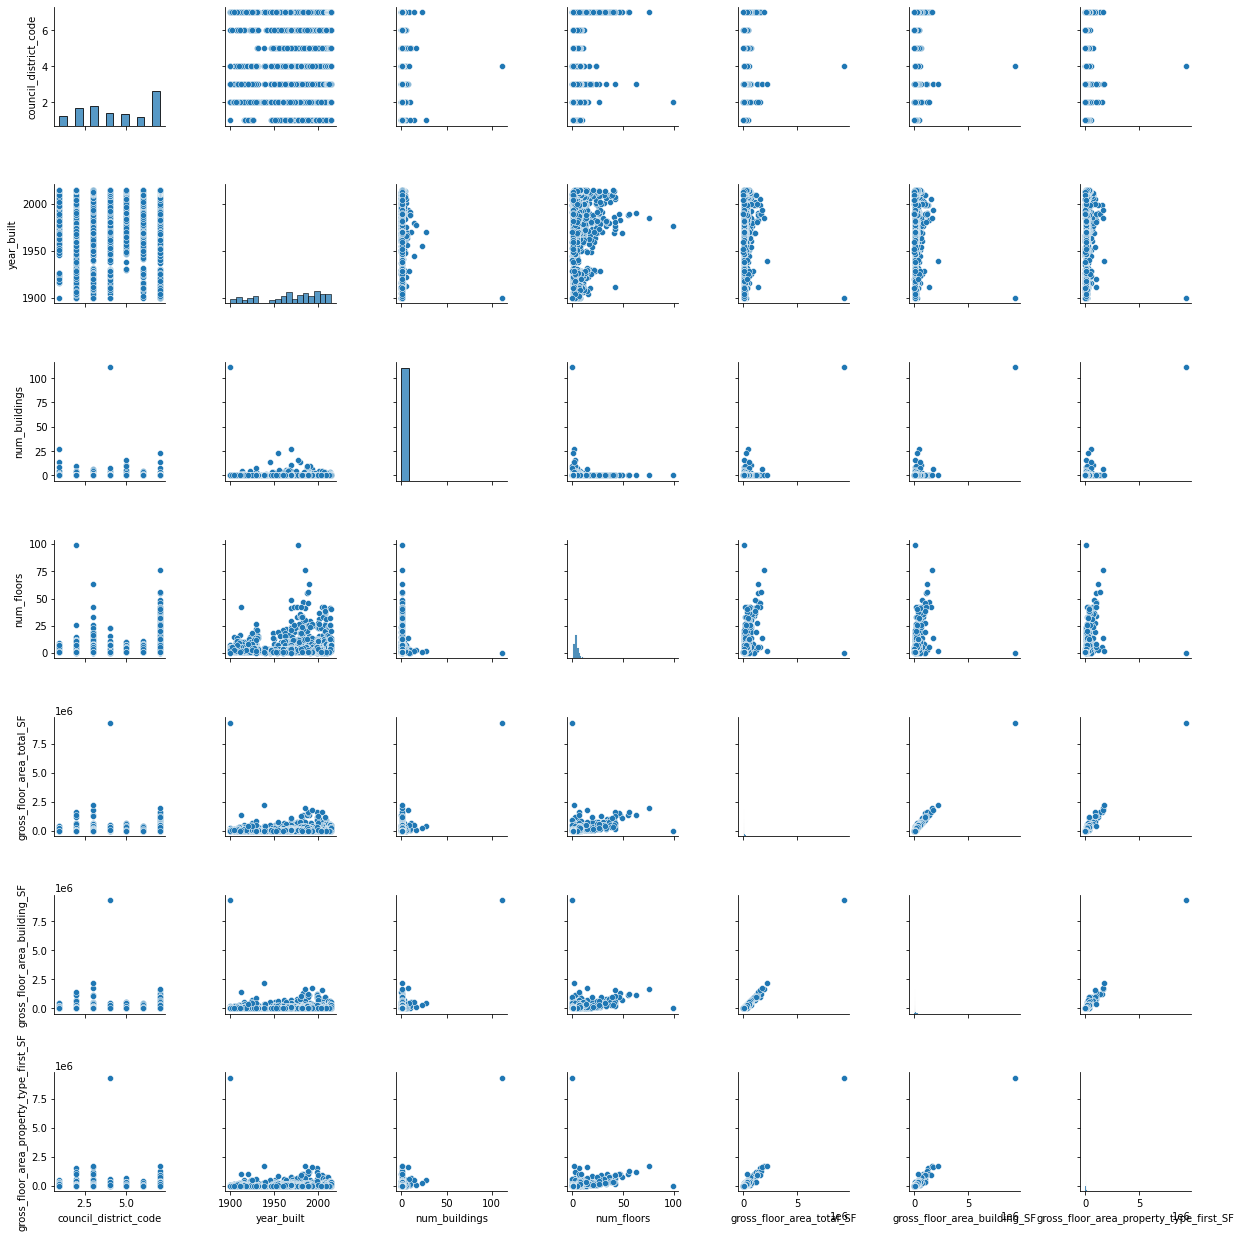

In [360]:
# THIS TAKES A LOOOONG TIME! ~10 MINUTES ON COLAB FOR ME
import seaborn as sns
sns.pairplot(X_seattle_numeric_data)
# DELETE OUTPUT!

In [361]:
X_seattle_numeric_data.head()

,council_district_code,year_built,num_buildings,num_floors,gross_floor_area_total_SF,gross_floor_area_building_SF,gross_floor_area_property_type_first_SF
0,7,1927,1,12,88434.0,88434.0,88434.0
1,7,1996,1,11,103566.0,88502.0,83880.0
2,7,1969,1,41,956110.0,759392.0,756493.0
3,7,1926,1,10,61320.0,61320.0,61320.0
4,7,1980,1,18,175580.0,113580.0,123445.0


In [362]:
X_dc_numeric_data.head()

,ward,year_built,tax_record_floor_area,reported_gross_floor_area,water_use
0,4,1959,63227.0,65000.0,6963.5
1,2,1997,251557.0,257943.0,8490.0
2,2,1964,330550.0,223218.0,8749.1
3,2,1969,256839.0,213067.0,5393.8
4,2,1975,370000.0,381518.0,10422.6


In [363]:
X_chicago_numeric_data.head()

,Gross.Floor.Area...Buildings..sq.ft.,Year.Built,X..of.Buildings
0,99000.0,2000,1
1,92072.0,2014,1
2,136000.0,1924,1
3,182246.0,1964,1
4,193497.0,1930,1


In [364]:
# which rows should you drop?
#X_seattle_numeric_data.drop(["Latitude",	"Longitude"], axis = 1)
#Everything is already droped

In [365]:
X_seattle_numeric_data.describe()

,council_district_code,year_built,num_buildings,num_floors,gross_floor_area_total_SF,gross_floor_area_building_SF,gross_floor_area_property_type_first_SF
count,3237.000000,3237.000000,3237.000000,3237.000000,3.237000e+03,3.237000e+03,3.237000e+03
mean,4.435897,1968.331480,1.104109,4.776336,9.379247e+04,8.592918e+04,7.802448e+04
std,2.121025,33.253769,2.137712,5.554374,2.199404e+05,2.087950e+05,2.018149e+05
min,1.000000,1900.000000,0.000000,0.000000,1.128500e+04,1.128500e+04,5.656000e+03
25%,3.000000,1948.000000,1.000000,2.000000,2.830900e+04,2.758000e+04,2.498800e+04
50%,4.000000,1974.000000,1.000000,4.000000,4.379400e+04,4.290500e+04,3.952000e+04
75%,7.000000,1997.000000,1.000000,5.000000,8.954900e+04,8.311800e+04,7.517400e+04
max,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,9.320156e+06,9.320156e+06


In [366]:
X_dc_numeric_data.describe()

,ward,year_built,tax_record_floor_area,reported_gross_floor_area,water_use
count,1455.000000,1455.000000,1.455000e+03,1.455000e+03,1.455000e+03
mean,3.472852,1940.804811,2.046748e+05,1.897612e+05,5.109905e+04
std,2.047691,167.230361,2.451302e+05,2.436786e+05,6.163321e+05
min,1.000000,1000.000000,9.171000e+03,9.171000e+03,0.000000e+00
25%,2.000000,1947.000000,7.164000e+04,7.111750e+04,1.958050e+03
50%,2.000000,1971.000000,1.287720e+05,1.215530e+05,4.063800e+03
75%,5.000000,1994.000000,2.585310e+05,2.372130e+05,7.008700e+03
max,8.000000,2017.000000,3.997572e+06,5.634890e+06,1.929391e+07


In [367]:
X_chicago_numeric_data.describe()

,Gross.Floor.Area...Buildings..sq.ft.,Year.Built,X..of.Buildings
count,2.688000e+03,2688.000000,2688.000000
mean,2.448678e+05,1962.942336,1.405878
std,3.964045e+05,36.294735,5.201993
min,5.000000e+04,1872.000000,1.000000
25%,7.500000e+04,1928.000000,1.000000
50%,1.237265e+05,1969.000000,1.000000
75%,2.521352e+05,1997.000000,1.000000
max,9.245333e+06,2016.000000,236.000000


In [368]:
# this does not have to be identical to my output as you may have dropped different variables
print("Seattle: there are (rows, columns) = ", X_seattle_numeric_data.shape, "in the numerical variables")
print("DC: there are (rows, columns) = ", X_dc_numeric_data.shape, "in the numerical variables")
print("Chicago: there are (rows, columns) = ", X_chicago_numeric_data.shape, "in the numerical variables")

Seattle: there are (rows, columns) =  (3237, 7) in the numerical variables
DC: there are (rows, columns) =  (1455, 5) in the numerical variables
Chicago: there are (rows, columns) =  (2688, 3) in the numerical variables


As they do in the original research https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd we should transform some variables into their log values 

their original code (which is in R not in python!) is
```
x_seattle$log_total_area=log(x_seattle$gross_floor_area_total_SF)
x_seattle$log_parking_area=log(x_seattle$gross_floor_area_parking_SF)
x_seattle$log_bldg_area=log(x_seattle$gross_floor_area_building_SF)
x_seattle$log_area_1=log(x_seattle$gross_floor_area_property_type_first_SF)

```
the names are a bit different


In [369]:
# note: recheck missing values 
# this is important: after I apply the log function to some variables cause log(0) = -infinity
print("Seattle: there are {} missing or infinity values in the numerical data".format(X_seattle_numeric_data.isnull().sum().sum()))
print("DC: there are {} missing or infinity values in the numerical data".format(X_dc_numeric_data.isnull().sum().sum()))
print("Chicago: there are {} missing or infinity values in the numerical data".format(X_chicago_numeric_data.isnull().sum().sum()))



Seattle: there are 0 missing or infinity values in the numerical data
DC: there are 0 missing or infinity values in the numerical data
Chicago: there are 0 missing or infinity values in the numerical data


In [370]:
# translated to python
#X_seattle_numeric_data["PropertyGFATotal"] = np.log10(X_seattle_numeric_data["PropertyGFATotal"])

# Seattle
X_seattle_numeric_data["log_total_area"] = np.log10(X_seattle_numeric_data["gross_floor_area_total_SF"])
#X_seattle_numeric_data["log_parking_area"] = np.log10(X_seattle_numeric_data["gross_floor_area_parking_SF"])
X_seattle_numeric_data["log_bldg_area"] = np.log10(X_seattle_numeric_data["gross_floor_area_building_SF"])
X_seattle_numeric_data["log_area_1"] = np.log10(X_seattle_numeric_data["gross_floor_area_property_type_first_SF"])

# DC
X_dc_numeric_data["log_floor_area_tax"] = np.log10(X_dc_numeric_data["tax_record_floor_area"])


# Chicago
X_chicago_numeric_data["log_total_area"] = np.log10(X_chicago_numeric_data["Gross.Floor.Area...Buildings..sq.ft."])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [371]:
print("Seattle: number of infinite values:", (np.isinf(X_seattle_numeric_data)).sum().sum())
print("DC: number of infinite values:", (np.isinf(X_dc_numeric_data)).sum().sum())
print("Chicago: number of infinite values:", (np.isinf(X_chicago_numeric_data)).sum().sum())

Seattle: number of infinite values: 0
DC: number of infinite values: 0
Chicago: number of infinite values: 0


check what happened to missing values: they may have grown! because  log(0) = -infinity - fix infinities replacing them with NaN 

(in in https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd they had replaced them with 0 but I object to that)

In [372]:
# this has to return 0 now
# Seattle
X_seattle_numeric_data.replace(-np.inf, np.nan, inplace=True)
print("Seattle: number of infinite values:", (np.isinf(X_seattle_numeric_data)).sum().sum())
# DC
X_dc_numeric_data.replace(-np.inf, np.nan, inplace=True)
print("DC: number of infinite values:", (np.isinf(X_dc_numeric_data)).sum().sum())
# Chicago
X_chicago_numeric_data.replace(-np.inf, np.nan, inplace=True)
print("Chicago: number of infinite values:", (np.isinf(X_chicago_numeric_data)).sum().sum())

Seattle: number of infinite values: 0
DC: number of infinite values: 0
Chicago: number of infinite values: 0


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [373]:
print("Seattle: the numerical data contains (rows, columns) = ", X_seattle_numeric_data.shape)
print("there are {} missing values in the numerical data".format(X_seattle_numeric_data.isnull().sum().sum()))

print("DC: the numerical data contains (rows, columns) = ", X_dc_numeric_data.shape)
print("there are {} missing values in the numerical data".format(X_dc_numeric_data.isnull().sum().sum()))

print("Chicago: the numerical data contains (rows, columns) = ", X_chicago_numeric_data.shape)
print("there are {} missing values in the numerical data".format(X_chicago_numeric_data.isnull().sum().sum()))

Seattle: the numerical data contains (rows, columns) =  (3237, 10)
there are 0 missing values in the numerical data
DC: the numerical data contains (rows, columns) =  (1455, 6)
there are 0 missing values in the numerical data
Chicago: the numerical data contains (rows, columns) =  (2688, 4)
there are 0 missing values in the numerical data



you can use `KNNImputer` on the numerical variables, but KNNImputer would fail on categorical variables so you are left with NaNs on categorical variables, which you then need to drop before you run the Random Forest


You can impute separately the numerical and categorical variables, the numerical ones with KNNImputer and the categorical ones with SimpleImputer

## TASK 2.2 use Nearest Neighbor Imputer to impute missing values in numerical features

here we are deviating from the paper. NN imputation is simpler and more common, I think it may be more useful to you in general

In [374]:
X_seattle_numeric_data

,council_district_code,year_built,num_buildings,num_floors,gross_floor_area_total_SF,gross_floor_area_building_SF,gross_floor_area_property_type_first_SF,log_total_area,log_bldg_area,log_area_1
0,7,1927,1,12,88434.0,88434.0,88434.0,4.946619,4.946619,4.946619
1,7,1996,1,11,103566.0,88502.0,83880.0,5.015217,4.946953,4.923658
2,7,1969,1,41,956110.0,759392.0,756493.0,5.980508,5.880466,5.878805
3,7,1926,1,10,61320.0,61320.0,61320.0,4.787602,4.787602,4.787602
4,7,1980,1,18,175580.0,113580.0,123445.0,5.244475,5.055302,5.091474
...,...,...,...,...,...,...,...,...,...,...
3232,1,1982,1,1,18261.0,18261.0,18261.0,4.261525,4.261525,4.261525
3233,2,1990,1,1,12294.0,12294.0,12294.0,4.089693,4.089693,4.089693
3234,2,2004,1,1,16000.0,16000.0,16000.0,4.204120,4.204120,4.204120
3235,1,1989,1,1,14101.0,14101.0,6601.0,4.149250,4.149250,3.819610


In [375]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3, weights="distance")

Xn_seattle = imputer.fit_transform(X_seattle_numeric_data)
Xn_seattle

array([[7.00000000e+00, 1.92700000e+03, 1.00000000e+00, ...,
        4.94661927e+00, 4.94661927e+00, 4.94661927e+00],
       [7.00000000e+00, 1.99600000e+03, 1.00000000e+00, ...,
        5.01521720e+00, 4.94695309e+00, 4.92365842e+00],
       [7.00000000e+00, 1.96900000e+03, 1.00000000e+00, ...,
        5.98050786e+00, 5.88046602e+00, 5.87880491e+00],
       ...,
       [2.00000000e+00, 2.00400000e+03, 1.00000000e+00, ...,
        4.20411998e+00, 4.20411998e+00, 4.20411998e+00],
       [1.00000000e+00, 1.98900000e+03, 1.00000000e+00, ...,
        4.14924991e+00, 4.14924991e+00, 3.81960973e+00],
       [2.00000000e+00, 1.93800000e+03, 1.00000000e+00, ...,
        4.26145320e+00, 4.26145320e+00, 3.91755802e+00]])

## TASK 2.3 Impute missing categorial variables 
you will have to remove Nan values and replace them. 

You can use `sklearn.impute.SimpleImputer using strategy="most_frequent"` on all variables, but you will have a naif solution for numerical imputations

I prefer to replace them with "None" or a similar string, for which you can use the fillna method: ```df.fillna("None")``` and leave it at that or with a little more effort you can input values based on nearest neighbors or some other inputation scheme. any choice goes so long as it is well described and justified with words.

In [376]:
### here you replace NaN in categorical with one of the options above
#from sklearn.impute import SimpleImputer

#cat_imputer = SimpleImputer(n_neighbors=3, weights="distance")

#Xn = imputer.fit_transform(X_seattle_numeric_data)
#Xn

X_seattle_categorical_data.info()
# only property_type_first has null values
X_seattle_categorical_data["property_type_first"].unique()
X_seattle_categorical_data.fillna("None",inplace=True)
X_seattle_categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3237 entries, 0 to 3236
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   building_type          3237 non-null   object
 1   property_type_primary  3237 non-null   object
 2   zip                    3237 non-null   object
 3   neighborhood           3237 non-null   object
 4   property_type_first    3222 non-null   object
dtypes: object(5)
memory usage: 280.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3237 entries, 0 to 3236
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   building_type          3237 non-null   object
 1   property_type_primary  3237 non-null   object
 2   zip                    3237 non-null   object
 3   neighborhood           3237 non-null   object
 4   property_type_first    3237 non-null   object
dtypes: object(5)
memory usage: 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [377]:
#checking the other cities
X_dc_categorical_data.info()
#dc is ok
X_chicago_categorical_data.info()
#chicago is ok

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1454
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   report_status         1455 non-null   object
 1   postal_code           1455 non-null   object
 2   primary_ptype_self    1455 non-null   object
 3   primary_ptype_epa     1455 non-null   object
 4   metered_areas_energy  1455 non-null   object
 5   metered_areas_water   1455 non-null   object
dtypes: object(6)
memory usage: 79.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2688 entries, 0 to 2687
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Primary.Property.Type  2688 non-null   object
dtypes: object(1)
memory usage: 42.0+ KB


# TASK 3 One Hot Encode the Categorical Variables

Hint: Once you have done the fit and the transformation, which gives you the transformed data according to the new encoding, what you get is normally a sparse matrix. In principle there is an argument `sparse` to `OneHotEncoder` which should prevent this and give you a dense matrix, which is much easier to handle (consider asking me or looking up what is a sparse matrix!). That attribute did not work for me so once I applied the new encoding I converted the result to a dense matrix as 
`Xc = Xc.todense()`

Finally, you will need to use a specific method to get the new names of the variables. Its a method of your model (which I called ohe below) and you can find it in this page here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [378]:
X_seattle_categorical_data.describe()

,building_type,property_type_primary,zip,neighborhood,property_type_first
count,3237,3237,3237,3237,3237
unique,8,24,53,19,55
top,NonResidential,Low-Rise Multifamily,98109,DOWNTOWN,Multifamily Housing
freq,1355,983,274,555,1664


In [379]:
X_dc_categorical_data.describe()

,report_status,postal_code,primary_ptype_self,primary_ptype_epa,metered_areas_energy,metered_areas_water
count,1455,1455,1455,1455,1455,1455
unique,2,52,45,45,3,3
top,In Compliance,20005,Office,Multifamily Housing,Whole Building,Whole Building
freq,1411,139,490,485,1434,1434


In [380]:
X_chicago_categorical_data.describe()

,Primary.Property.Type
count,2688
unique,47
top,Multifamily Housing
freq,1334


In [381]:
#from sklearn.preprocessing import OneHotEncoder
# DELETE
#your code here

#ohe = OneHotEncoder(handle_unknown='ignore')
#ohe.fit(X_seattle_categorical_data)
#ohe.categories_
#ohe.transform().toarray()

In [382]:
Xc_seattle = pd.get_dummies(X_seattle_categorical_data)
Xc_dc = pd.get_dummies(X_dc_categorical_data)
Xc_chicago = pd.get_dummies(X_chicago_categorical_data)

In [383]:
X_seattle_numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3237 entries, 0 to 3236
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   council_district_code                    3237 non-null   int64  
 1   year_built                               3237 non-null   int64  
 2   num_buildings                            3237 non-null   int64  
 3   num_floors                               3237 non-null   int64  
 4   gross_floor_area_total_SF                3237 non-null   float64
 5   gross_floor_area_building_SF             3237 non-null   float64
 6   gross_floor_area_property_type_first_SF  3237 non-null   float64
 7   log_total_area                           3237 non-null   float64
 8   log_bldg_area                            3237 non-null   float64
 9   log_area_1                               3237 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 407.2 KB


In [384]:
# there is a speific method of ohe that allows you to get the names of the features after the encoding is done
#feature_name_cat = ohe.categories_  ...... #replace ... with your code

# Task 4 recombine your numerical and categorical imput features and split your data into training and testing

In [385]:
#X_seattle = np.hstack([X_seattle_numeric_data, Xc_seattle])
#X_seattle.shape
X_seattle = pd.concat([X_seattle_numeric_data, Xc_seattle], axis=1)

#X_dc = np.hstack([X_dc_numeric_data, Xc_dc])
#X_dc.shape
X_dc = pd.concat([X_dc_numeric_data, Xc_dc], axis=1)

#X_dc = np.hstack([X_dc_numeric_data, Xc_dc])
#X_chicago.shape
#X_chicago = np.hstack([X_chicago_numeric_data, Xc_chicago])
X_chicago = pd.concat([X_chicago_numeric_data, Xc_chicago], axis=1)

In [386]:
X_seattle

,council_district_code,year_built,num_buildings,num_floors,gross_floor_area_total_SF,gross_floor_area_building_SF,gross_floor_area_property_type_first_SF,log_total_area,log_bldg_area,log_area_1,...,property_type_first_Restaurant,property_type_first_Retail Store,property_type_first_Self-Storage Facility,property_type_first_Senior Care Community,property_type_first_Social/Meeting Hall,property_type_first_Strip Mall,property_type_first_Supermarket/Grocery Store,property_type_first_Urgent Care/Clinic/Other Outpatient,property_type_first_Wholesale Club/Supercenter,property_type_first_Worship Facility
0,7,1927,1,12,88434.0,88434.0,88434.0,4.946619,4.946619,4.946619,...,0,0,0,0,0,0,0,0,0,0
1,7,1996,1,11,103566.0,88502.0,83880.0,5.015217,4.946953,4.923658,...,0,0,0,0,0,0,0,0,0,0
2,7,1969,1,41,956110.0,759392.0,756493.0,5.980508,5.880466,5.878805,...,0,0,0,0,0,0,0,0,0,0
3,7,1926,1,10,61320.0,61320.0,61320.0,4.787602,4.787602,4.787602,...,0,0,0,0,0,0,0,0,0,0
4,7,1980,1,18,175580.0,113580.0,123445.0,5.244475,5.055302,5.091474,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3232,1,1982,1,1,18261.0,18261.0,18261.0,4.261525,4.261525,4.261525,...,0,0,0,0,0,0,0,0,0,0
3233,2,1990,1,1,12294.0,12294.0,12294.0,4.089693,4.089693,4.089693,...,0,0,0,0,0,0,0,0,0,0
3234,2,2004,1,1,16000.0,16000.0,16000.0,4.204120,4.204120,4.204120,...,0,0,0,0,0,0,0,0,0,0
3235,1,1989,1,1,14101.0,14101.0,6601.0,4.149250,4.149250,3.819610,...,0,0,0,0,0,0,0,0,0,0


In [387]:
print("Seattle: The dataset has {} features (!!!)".format(X_seattle.shape[1]))
print("DC: The dataset has {} features (!!!)".format(X_dc.shape[1]))
print("Chicago: The dataset has {} features (!!!)".format(X_chicago.shape[1]))

Seattle: The dataset has 169 features (!!!)
DC: The dataset has 156 features (!!!)
Chicago: The dataset has 51 features (!!!)


In [388]:
y_chicago.shape

(2688, 1)

In [389]:
X_chicago.shape

(2688, 51)

In [390]:
# make a train and test dataset
from sklearn.model_selection import train_test_split

X_seattle_train, X_seattle_test, y_seattle_train, y_seattle_test = train_test_split(X_seattle, y_seattle, train_size=0.75, random_state=123)
X_dc_train, X_dc_test, y_dc_train, y_dc_test = train_test_split(X_dc, y_dc, train_size=0.75, random_state=123)
X_chicago_train, X_chicago_test, y_chicago_train, y_chicago_test = train_test_split(X_chicago, y_chicago, train_size=0.75, random_state=123)

# TASK 5 run a random forest REGRESSION model

report the score on the tranining and test data and identify the most important features

(hint: if you see "ValueError: Input contains NaN, infinity or a value too large for dtype('float64')." check 
1. np.isnan(Xn).sum().sum() and np.isnan(Xc).sum().sum() both return 0
2. np.isinf(Xn).sum().sum() returns 0
3. all the feature that had very large numbers (> 1e5) have been converted to the log of their values

In [391]:
X_seattle_test

,council_district_code,year_built,num_buildings,num_floors,gross_floor_area_total_SF,gross_floor_area_building_SF,gross_floor_area_property_type_first_SF,log_total_area,log_bldg_area,log_area_1,...,property_type_first_Restaurant,property_type_first_Retail Store,property_type_first_Self-Storage Facility,property_type_first_Senior Care Community,property_type_first_Social/Meeting Hall,property_type_first_Strip Mall,property_type_first_Supermarket/Grocery Store,property_type_first_Urgent Care/Clinic/Other Outpatient,property_type_first_Wholesale Club/Supercenter,property_type_first_Worship Facility
2116,1,1996,1,6,20078.0,20078.0,20078.0,4.302720,4.302720,4.302720,...,0,0,0,0,0,0,0,0,0,0
43,7,1910,1,8,59400.0,59400.0,34947.0,4.773786,4.773786,4.543410,...,0,0,0,0,0,0,0,0,0,0
1482,7,1960,1,1,56884.0,56884.0,56884.0,4.754990,4.754990,4.754990,...,0,0,0,0,0,0,0,0,0,0
2005,4,1946,1,1,24295.0,24295.0,24295.0,4.385517,4.385517,4.385517,...,0,0,0,0,0,0,0,0,0,1
2460,3,1960,1,5,46527.0,46527.0,46527.0,4.667705,4.667705,4.667705,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,6,2003,1,4,42984.0,42984.0,32063.0,4.633307,4.633307,4.506004,...,0,0,0,0,0,0,0,0,0,0
621,2,1979,1,1,26380.0,26380.0,23620.0,4.421275,4.421275,4.373280,...,0,0,0,0,0,0,0,0,0,0
1036,4,1988,1,3,21118.0,21118.0,21118.0,4.324653,4.324653,4.324653,...,0,0,0,0,0,0,0,0,0,0
2539,4,1926,1,3,22018.0,22018.0,22018.0,4.342778,4.342778,4.342778,...,0,0,0,0,0,0,0,0,0,0


In [392]:
from sklearn.ensemble import RandomForestRegressor
rf_seattle = RandomForestRegressor(max_depth=6, random_state=123);
rf_seattle.fit(X_seattle_train, y_seattle_train);
print("Seattle: accuracy on training data {:.2}".format(rf_seattle.score(X_seattle_train, y_seattle_train)))
print("Seattle: accuracy on testing data {:.2}".format(rf_seattle.score(X_seattle_test, y_seattle_test)))

rf_dc = RandomForestRegressor(max_depth=6, random_state=123);
rf_dc.fit(X_dc_train, y_dc_train);
print("DC: accuracy on training data {:.2}".format(rf_dc.score(X_dc_train, y_dc_train)))
print("DC: accuracy on testing data {:.2}".format(rf_dc.score(X_dc_test, y_dc_test)))

rf_chicago = RandomForestRegressor(max_depth=6, random_state=123);
rf_chicago.fit(X_chicago_train, y_chicago_train);
print("Chicago: accuracy on training data {:.2}".format(rf_chicago.score(X_chicago_train, y_chicago_train)))
print("Chicago: accuracy on testing data {:.2}".format(rf_chicago.score(X_chicago_test, y_chicago_test)))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Seattle: accuracy on training data 0.82
Seattle: accuracy on testing data 0.72


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


DC: accuracy on training data 0.85
DC: accuracy on testing data 0.78


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Chicago: accuracy on training data 0.82
Chicago: accuracy on testing data 0.76


In [393]:
#this is how you see the importance of the features
rf_seattle.feature_importances_[:10]

array([0.00081071, 0.01435248, 0.00182466, 0.0034769 , 0.37570951,
       0.01035159, 0.07054963, 0.37833231, 0.01157224, 0.05421531])

In [397]:

feature_names = X_seattle.columns[:10]
feature_names

Index(['council_district_code', 'year_built', 'num_buildings', 'num_floors',
       'gross_floor_area_total_SF', 'gross_floor_area_building_SF',
       'gross_floor_area_property_type_first_SF', 'log_total_area',
       'log_bldg_area', 'log_area_1'],
      dtype='object')

In [398]:
imp_seattle = pd.DataFrame()
imp_seattle["features"] = X_seattle.columns
imp_seattle["importances"] = rf_seattle.feature_importances_

imp_dc = pd.DataFrame()
imp_dc["features"] = X_dc.columns
imp_dc["importances"] = rf_dc.feature_importances_

imp_chicago = pd.DataFrame()
imp_chicago["features"] = X_chicago.columns
imp_chicago["importances"] = rf_chicago.feature_importances_


In [402]:
imp_seattle.sort_values("importances", ascending=False)[:50].index

Int64Index([  7,   4,   6,   9, 133,   1,   8,   5,  40, 161,  30,  35,  14,
             25,   3, 135,  12,  27,   2, 101,  52, 138, 119,  13,  38,  18,
            165, 137,   0,  77, 160,  15,  28,  84, 104, 146,  97, 103, 125,
             21,  71,  70,  37,  55,  69,  36, 156, 162,  59,  60],
           dtype='int64')

KeyError: ignored

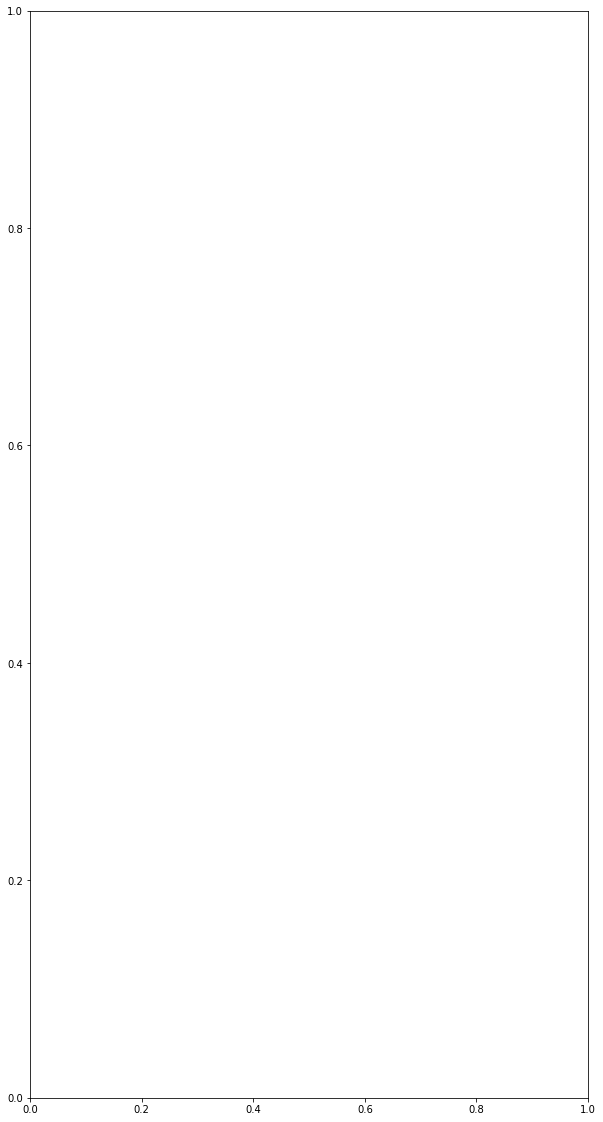

In [403]:
# plot the top ~50 features
import pylab as plt
feature_names = imp_seattle["features"]
sorted_idx = imp_seattle.sort_values("importances", ascending=False)[:50].index

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10,20))
ax.barh(y_ticks, imp_seattle[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
ax.set_ylim(550, len(feature_names))
plt.show()

#your plot may be different from mine

In [ ]:
# CAPTION HERE! How is your model, How is your feature importance results? what can you notice? is it interesting? is it insightful??

# TASK 6 do it for another city! note: the variable names wont be the same


# useful links and methods and functions I used: 

```df.dropna()``` to remove observation with missing variables

```df.drop(columns, axis=1)``` to remove features (columns)


```np.log10()``` and ```np.isinf()``` to convert to log space and find infinite values  

`np.hstack([X1, X2])` to concatenate two arrays


one hot encoder https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html and https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/


KNN imputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html , https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/, and 
https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/  